## CREATE SAMPLE 2

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from __future__ import print_function
%matplotlib inline
import argparse
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from collections import Counter
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
from torchvision import datasets, transforms, models

In [5]:
path = os.path.abspath('/content/drive/MyDrive/Colab Notebooks')
os.chdir(path)
print(path)

/content/drive/MyDrive/Colab Notebooks


In [6]:
SEED =  12321
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

### Helper functions

In [7]:
def plot_histogram(data, plot_properties):
  """ Generic function to plot a histogram.
      param: data- is an 1D array of data
      param: plot_properties- a dictionary of properties like:
      {"title":"","xlabel":"","ylabel":""}
  """
  plt.figure(figsize=(10, 6))
  plt.hist(data)
  plt.grid(False)
  plt.title(plot_properties["title"])
  plt.xlabel(plot_properties["xlabel"])
  plt.ylabel(plot_properties["ylabel"])
  plt.show()


def plot_box(data, plot_properties):
  """ Generic function to plot a box plot.
      param: data- is an 1D array of data
      param: plot_properties- a dictionary of properties like:
      {"title":"","xlabel":"","ylabel":""}
  """
  plt.figure(figsize=(10, 6))
  plt.boxplot(data)
  plt.grid(False)
  plt.title(plot_properties["title"])
  plt.xlabel(plot_properties["xlabel"])
  plt.ylabel(plot_properties["ylabel"])
  plt.show()
    
def plot_count(data,plot_properties):
    """ Generic for a count plot.
      param: data- is an 1D array of data
      param: plot_properties- a dictionary of properties like:
      {"title":"","xlabel":"","ylabel":"", "x":""}
    """
    plt.figure(figsize=(10, 6))
    chart = sns.countplot(data,x=plot_properties['x'],palette='Set2')
    chart.set_xticklabels(chart.get_xticklabels(), 
                      rotation=45, horizontalalignment='right')
    plt.title(plot_properties["title"])
    plt.xlabel(plot_properties["xlabel"])
    plt.ylabel(plot_properties["ylabel"])
    plt.show()

def exploring_new_dataset(dataset):
  """ This function performs the role of
      displaying the common information about a dataset
  """
  print("Sample length",len(dataset))
  print(dataset.groupby('target').image_name.count())
  plot_count(dataset.benign_malignant, 
               {"title":"IMAGES BY GROUND TRUTH",
                "xlabel":"TARGET","ylabel":"NUMBER OF IMAGES","x":"target"})


In [8]:
def get_sample_from_df(sample,n):
    for i in list(range(n,0, -1)):
        if len(sample)>=i:
            return sample.sample(n=i, random_state=SEED).index[:i]
        
    return [];


def sample_by_patient(dataset,num_sample=1):
  """ Get patient id as category
   Prepare two datasets:
   for each patient_id
       select get records
         if malignant
           sample num_sample
         elif benign
           sample num_sample"""
  unique_patient_id = dataset.patient_id.cat.categories
  malignant_df = dataset[dataset['target'] == 1]
  benign_df = dataset[dataset['target'] == 0]
  sample_indices = []
  #samples per patient
  for  patient_id in unique_patient_id:
      patient_sample = malignant_df[malignant_df['patient_id']==patient_id]
      if len(patient_sample):
          sample_indices.extend(get_sample_from_df(patient_sample,num_sample))
      else:
          patient_sample = benign_df[benign_df['patient_id']==patient_id]
          sample_indices.extend(get_sample_from_df(patient_sample,num_sample))

  return dataset.loc[sample_indices]

def perform_sampling(dataset,sampling_type="", patient_group_sample=1):
  """function to perform sampling based on
     the sampling type provided.
     Return train, test dataset
  """
  train = None
  test = None
  if sampling_type=="PATIENT_GROUP":
    sample=sample_by_patient(dataset,patient_group_sample)
    train, test = train_test_split(sample, test_size=0.2, shuffle=True, random_state=SEED)
  else:
    # default train_test split by 8:2
    train, test = train_test_split(dataset, test_size=0.2, shuffle=True, random_state=SEED)

  return train,test;   


In [34]:
def set_image_file_name(row,base_path):
    """We create the image file name"""
    file = row["image_name"]+".jpg"
    file_path = os.path.join(base_path, file)
    return file_path if os.path.exists(file_path) else np.nan

def create_benign_malignant_column(row):
    """Create benign and malignant classes from HAM10000"""
    if(row['dx']=="mel"):
      return "malignant"
    if(row['dx']=="bkl"):
      return "malignant"
    if(row['dx']=="bcc"):
      return "malignant"     
    elif row['dx']=="nv":
      return "benign"
    else:    
     return np.nan    

### Load Ham10000

In [49]:
ham10000_df = pd.read_csv("HAM10000_metadata.csv")
ham10000_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [50]:
print("The number of rows and columne in train.csv: {}".format(ham10000_df.shape))
print(ham10000_df.columns)
print("\nDATA TYPES\n")
print(ham10000_df.dtypes)
print("\n=================================================\n")
print("\nCOLUMN COUNT\n")
print(ham10000_df.count())
print("\nNULL COUNT\n")
print(ham10000_df.isnull().sum())

The number of rows and columne in train.csv: (10015, 7)
Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], dtype='object')

DATA TYPES

lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dtype: object



COLUMN COUNT

lesion_id       10015
image_id        10015
dx              10015
dx_type         10015
age              9958
sex             10015
localization    10015
dtype: int64

NULL COUNT

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64


In [51]:
ham10000_df = ham10000_df[['image_id','dx']]
ham10000_df.head()

,image_id,dx
0,ISIC_0027419,bkl
1,ISIC_0025030,bkl
2,ISIC_0026769,bkl
3,ISIC_0025661,bkl
4,ISIC_0031633,bkl


In [52]:
ham10000_df.columns

Index(['image_id', 'dx'], dtype='object')

In [60]:
ham10000_df['benign_malignant'] = ham10000_df.apply(create_benign_malignant_column, axis=1) 
ham10000_df=ham10000_df.rename(columns={'image_id':'image_name'}) 

In [55]:
ham10000_df.dropna(axis=0, inplace=True)
ham10000_df.info()
print(ham10000_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9431 entries, 0 to 10014
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   image_id          9431 non-null   object
 1   dx                9431 non-null   object
 2   benign_malignant  9431 non-null   object
dtypes: object(3)
memory usage: 294.7+ KB
image_id            0
dx                  0
benign_malignant    0
dtype: int64


In [61]:
ham10000_df=ham10000_df.astype({"benign_malignant": "category"})

In [62]:
ham10000_df['target']=ham10000_df.benign_malignant.cat.codes

In [63]:
ham10000_df.head()

,image_name,dx,benign_malignant,target
0,ISIC_0027419,bkl,malignant,1
1,ISIC_0025030,bkl,malignant,1
2,ISIC_0026769,bkl,malignant,1
3,ISIC_0025661,bkl,malignant,1
4,ISIC_0031633,bkl,malignant,1


Sample length 9431
target
0    6705
1    2726
Name: image_name, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


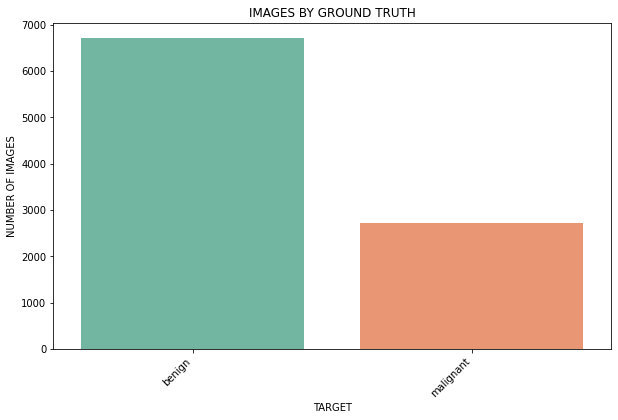

In [64]:
exploring_new_dataset(ham10000_df)

### Load SIIM 2020 the dataset
We load the train.csv dataset csv. Then perform the following:




In [67]:
isic_siim_df = pd.read_csv("train.csv")
isic_siim_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [69]:
isic_siim_df = isic_siim_df.astype({'patient_id':'category',"sex":'category', "diagnosis":'category',
                             'benign_malignant':'category','target':'category',
                             'anatom_site_general_challenge':'category'})

In [73]:
train, test = perform_sampling(isic_siim_df, "PATIENT_GROUP",patient_group_sample=1)

In [74]:
sample1 = pd.concat([train,test],ignore_index=True)

Sample length 2056
target
0    1628
1     428
Name: image_name, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


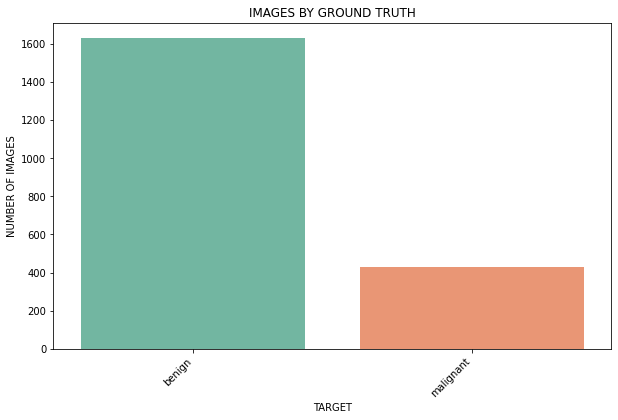

In [75]:
exploring_new_dataset(sample1)

### Load Sample 2

In [76]:
sample2_train = pd.read_csv("train_sample.csv")
sample2_test = pd.read_csv("test_sample.csv")
sample2 = pd.concat([sample2_train,sample2_test],ignore_index=True)

Sample length 9188
target
0    6661
1    2527
Name: image_name, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


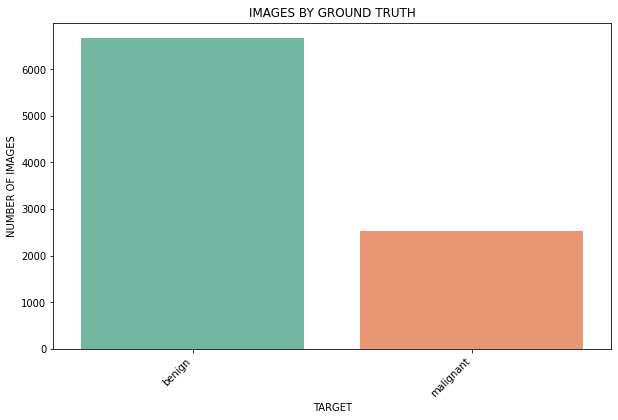

In [78]:
exploring_new_dataset(sample2_train)

Sample length 2299
target
0    1672
1     627
Name: image_name, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


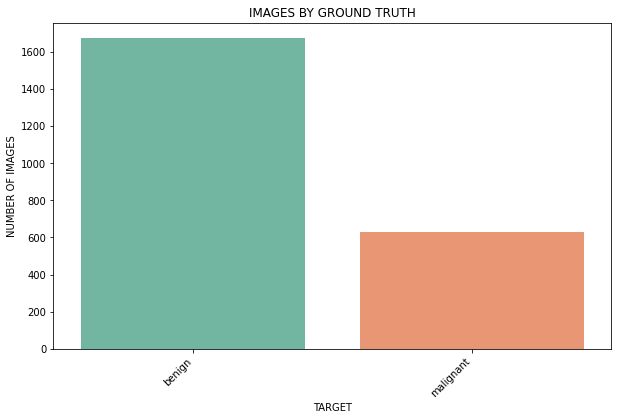

In [79]:
exploring_new_dataset(sample2_test)

Sample length 11487
target
0    8333
1    3154
Name: image_name, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


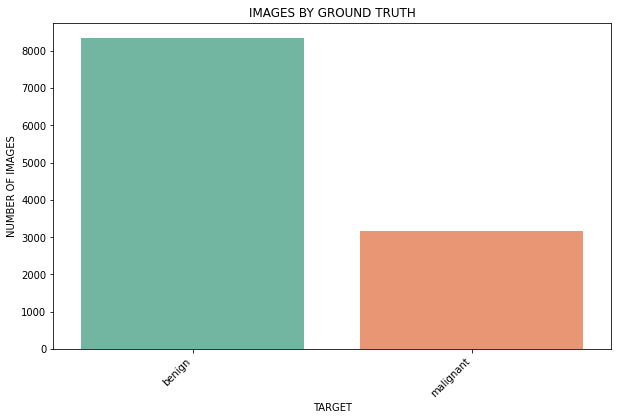

In [77]:
exploring_new_dataset(sample2)